# Imports

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh as PMnew
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time


# import os, sys
# sys.path.append('../cosmo4d/')
# from lab import *

# import h5py, bigfile, json
# import importlib
# import os, sys

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append("/global/homes/c/chmodi/Programs/cosmo4dv2/")
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4dv2/cosmo4d/')
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4dv2/train_nets')
import features as ft
import datalib as lib
import datatools as dtools
import nettools as ntools
import sigtools as stools
import diagnostic as dg
import mymass_function as mass_function
%matplotlib inline

from scipy.optimize import minimize


pfile = "/global/homes/c/chmodi/Data/ics_matterpow_0.dat"
klin, plin = np.loadtxt(pfile, unpack=True)
mf = mass_function.Mass_Func(pfile, 0.3175)
# cosmo = Planck15.clone(Omega_cdm = 0.2685, h = 0.6711, Omega_b = 0.049)

# from cosmo4d import maplhd as mapp
# from cosmo4d import nbody
# from cosmo4d import report as dgrep
# from cosmo4d.iotools import load_map as loadmap

# # sys.path.append('/global/homes/c/chmodi/Programs/Py_codes/modules/')
# # import mytools as tools
# # import mycosmology

# #import mysigmoid as sigmoid



In [4]:
seed, nsteps = 100, 5
bs, nc = 400., 128
pm = PMnew(BoxSize=bs, Nmesh=[nc, nc, nc], dtype = "f8")
numd = 1e-3
num = int(numd*pm.BoxSize.prod())
M0 = 1e11
Rsm = 3
zz = 0 


In [5]:
# proj = '/project/projectdirs/cosmosim/lbl/chmodi/cosmo4d/'
# scratch = '/global/cscratch1/sd/chmodi/cosmo4d/'
# train = scratch + 'train/'
# dpath = proj + 'data/L%04d_N%04d_S%04d_%02dstep/lhd/n%02d/'
# ppath = proj + 'train/L%04d_N%04d_%02dstep-n%02d/cfcl273noa/'%(bs, nc, nsteps, numd*1e4)
# outpath = scratch + 'output/L%04d_N%04d_%02dstep-fof/lhd_S%04d/n%02d/'


# outpath2 = proj + 'output/L%04d_N%04d_S%04d_%02dstep-fof/lhd/n%02d/'


In [6]:
def laplace(k, v):
    kk = sum(ki ** 2 for ki in k)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    b = v / kk
    b[mask] = 0
    return b



def gradient(dir, order=1):
    if order == 0:
        def kernel(k, v):
            # clear the nyquist to ensure field is real                         
            mask = v.i[dir] != v.Nmesh[dir] // 2
            return v * (1j * k[dir]) * mask
    if order == 1:
        def kernel(k, v):
            cellsize = (v.BoxSize[dir] / v.Nmesh[dir])
            w = k[dir] * cellsize

            a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
            # a is already zero at the nyquist to ensure field is real          
            return v * (1j * a)
    return kernel



def doza(dlin_k, q, resampler='cic'):
    """ Run first order LPT on linear density field, returns displacements of particles            
        reading out at q. The result has the same dtype as q.                                      
    """
    basepm = dlin_k.pm

    ndim = len(basepm.Nmesh)
    delta_k = basepm.create('complex')
    print(basepm)
    
    source = numpy.zeros((len(q), ndim), dtype=q.dtype)
    for d in range(len(basepm.Nmesh)):
        disp = dlin_k.apply(laplace) \
                    .apply(gradient(d), out=Ellipsis) \
                    .c2r(out=Ellipsis)
        source[..., d] = disp.readout(q, resampler=resampler)
        
    pos = q + source
    pos[pos < 0] += bs
    pos[pos > bs] -= bs
    return pos


# Bias Model

In [29]:
tmp = BigFileMesh('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step/mesh/', 'd')

In [30]:
tmp.

{'BoxSize': array([400., 400., 400.]),
 'Nmesh': array([128, 128, 128]),
 'ndarray.shape': array([128, 128, 128])}

In [36]:
data['Mass'].compute()[64000]*1e15/data['Mass'].compute()[1]/1e10

236.81783888004023

In [7]:
data = BigFileCatalog('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0512_S0100_40step/FOF/')
dyn = BigFileCatalog('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step/dynamic/1')
dynfpm = BigFileCatalog('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step_fpm//dynamic/1')
lin = BigFileMesh('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step/mesh/', 's').paint()
fin = BigFileMesh('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step/mesh/', 'd').paint()
ones = pm.create(type='real', value=1.)
# lin512 = BigFileMesh('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0512_S0100_40step/mesh/', 's').paint()
# fin512 = BigFileMesh('/project/projectdirs/m3035/chmodi/cosmo4d/data/z00/L0400_N0512_S0100_40step/mesh/', 'd').paint()

fin /= fin.cmean()
fin -= 1

fpos = dyn['Position'].compute()
fposfpm = dynfpm['Position'].compute()
fpos[fpos < 0] += bs
fpos[fpos > bs] -= bs
fposfpm[fposfpm < 0] += bs
fposfpm[fposfpm > bs] -= bs
grid = pm.mesh_coordinates()*bs/nc


In [37]:
finsm = ft.smooth(fin, 3, 'gauss')
dm = pm.paint(fpos)

hmesh = pm.paint(data['PeakPosition'][:num])
hmesh = pm.paint(data['PeakPosition'][:num], mass=data['Mass'][:num])
hmesh /= hmesh.cmean()
hmesh -= 1

In [8]:
zapos = doza(lin.r2c(), grid)
za = pm.paint(zapos)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


In [24]:
pos = fpos.copy()
pos = zapos.copy()

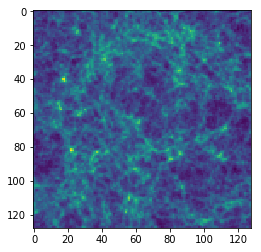

In [25]:
plt.imshow(za[...].sum(axis=0))

399.9996790571282
29.750807784866105
[5.15921205 5.54571281 6.16749303]


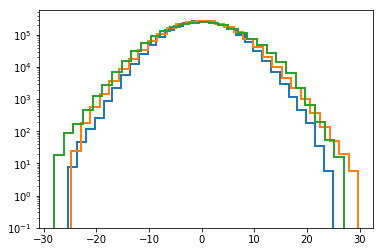

In [12]:
disp = zapos - grid
print(disp.max())
mask = abs(disp) > bs/2.
disp[mask] = (bs - abs(disp[mask]))*-np.sign(disp[mask])
print(disp.max())

print(disp.std(axis=0))

for i in range(3):
    plt.hist(disp[:,i], bins=30, log=True, histtype='step', alpha=1, lw=2)
plt.show()

399.9996559261922
199.9999767835772
[ 70.79122049 120.75589385   6.26875409]


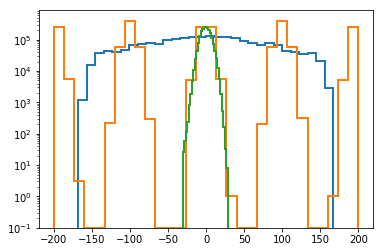

In [13]:
disp = (fpos - grid)
print(disp.max())
mask = abs(disp) > bs/2.
disp[mask] = (bs - abs(disp[mask]))*-np.sign(disp[mask])
print(disp.max())

print(disp.std(axis=0))

for i in range(3):
    plt.hist(disp[:,i], bins=30, log=True, histtype='step', alpha=1, lw=2)
plt.show()

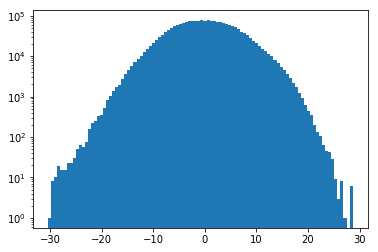

In [14]:
plt.hist(disp[:,2], bins=100, log=True)
plt.show()

In [26]:
disp = fposfpm - grid
dispsm = []

for i in range(3):
    tmp = pm.paint(grid, mass=disp[:, i], resampler='nearest')
    print(tmp[...].std())
    tmpsm = ft.smooth(tmp, 5, 'gauss')
    print(tmpsm[...].std())
    dispsm.append(tmpsm.readout(grid))
    
dispsm = np.array(dispsm)

40.15133989696861
21.285015023310994
37.63144398251762
19.745581568443757
36.52629712161528
18.61962382699751


In [10]:
# d0 = lin.copy()

# d2 = 1.*lin**2
# d2 -= d2.cmean()

# s2 = ft.shear(pm, lin)
# s2 -= 1.*lin**2
# s2 -= s2.cmean()

d0 = finsm.copy()

d2 = 1.*finsm**2
d2 -= d2.cmean()

s2 = ft.shear(pm, finsm)
s2 -= 1.*finsm**2
s2 -= s2.cmean()



In [19]:
# plt.plot(k, FFTPower(s2, mode='1d').power['power'])
# plt.plot(k, FFTPower(s2, second=d2, mode='1d').power['power'])
# plt.plot(k, -FFTPower(s2, second=d2, mode='1d').power['power'])
# plt.loglog()

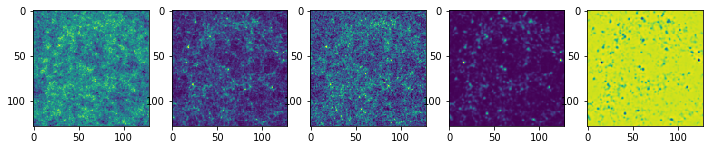

In [11]:
ii = 5

plt.figure(figsize = (12, 4))

plt.subplot(1,ii,1)
plt.imshow(lin[...].sum(axis=0))

plt.subplot(1,ii,2)
plt.imshow(fin[...].sum(axis=0))

plt.subplot(1,ii,3)
plt.imshow(hmesh[...].sum(axis=0))

plt.subplot(1,ii,4)
plt.imshow(d2[...].sum(axis=0))

plt.subplot(1,ii,5)
plt.imshow(s2[...].sum(axis=0))


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


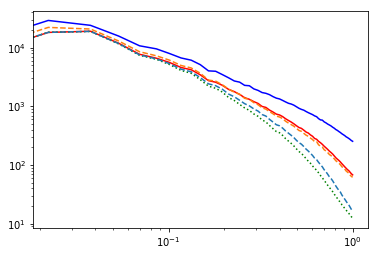

In [12]:
k = FFTPower(fin, mode='1d').power['k']
pf = FFTPower(fin, mode='1d').power['power']
pza = FFTPower(za, mode='1d').power['power']
pxfza = FFTPower(za, second=fin, mode='1d').power['power']
ph = FFTPower(hmesh, mode='1d').power['power']
pxfh = FFTPower(hmesh, second=fin, mode='1d').power['power']

# plt.plot(k, (pf/ph)**0.5)
plt.plot(k, pf, 'r')
plt.plot(k, pza, 'g:')
plt.plot(k, pxfza, '--')
plt.plot(k, ph, 'b')
plt.plot(k, pxfh, '--')
plt.xscale('log')
plt.yscale('log')


In [ ]:
pm.pait

[1. 1. 1. ... 1. 1. 1.]


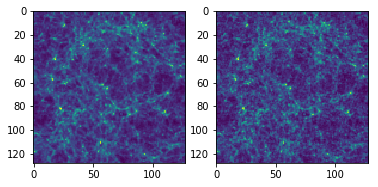

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


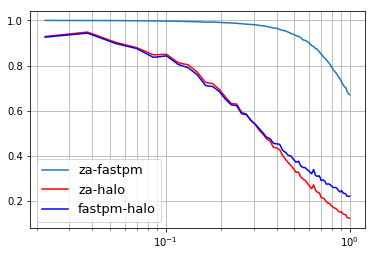

In [23]:
base = 1.*ones**1
# base = 1.*lin**2- (lin**2).cmean()
# base = 1.*s2
rd = base.readout(grid, resampler='nearest')
print(rd)

t1 = pm.paint(fposfpm, mass=rd, resampler='cic')
t2 = pm.paint(fpos, mass=rd, resampler='cic')

plt.subplot(121)
plt.imshow(t1[...].sum(axis=0))
plt.subplot(122)
plt.imshow(t2[...].sum(axis=0))
plt.show()

k = FFTPower(t1, mode='1d').power['k']
pt1 = FFTPower(t1, mode='1d').power['power']
pt2 = FFTPower(t2, mode='1d').power['power']
pxt12 = FFTPower(t1, second=t2, mode='1d').power['power']

plt.plot(k, pxt12**2/pt1/pt2, label='za-fastpm')
plt.xscale('log')
plt.grid(which='both')

pxt1h = FFTPower(t1, second=hmesh, mode='1d').power['power']
pxt2h = FFTPower(t2, second=hmesh, mode='1d').power['power']
plt.plot(k, pxt1h**2/ph/pt1, 'r', label='za-halo')
plt.plot(k, pxt2h**2/ph/pt2, 'b', label='fastpm-halo')
plt.legend(fontsize=13)
# PLT.YLABEL('rc')

In [14]:
# pos = fposfpm.copy()
pos = zapos.copy()

ed = pm.paint(pos, mass=ones.readout(grid, resampler='nearest'))
ed0 = pm.paint(pos, mass=d0.readout(grid, resampler='nearest'))
ed2 = pm.paint(pos, mass=d2.readout(grid, resampler='nearest'))
es2 = pm.paint(pos, mass=s2.readout(grid, resampler='nearest'))
# ed = pm.create(type='real', value=0)
# ed0 = d0.copy()
# ed2 = d2.copy()
# es2 = s2.copy()

# ed /= ed.cmean()
# ed0 /= ed0.cmean()
# ed2 /= ed2.cmean()
# es2 /= es2.cmean()

ped = FFTPower(ed, mode='1d').power['power']
ped0 = FFTPower(ed0, mode='1d').power['power']
ped2 = FFTPower(ed2, mode='1d').power['power']
pes2 = FFTPower(es2, mode='1d').power['power']

pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
pxhed0 = FFTPower(hmesh, second=ed0, mode='1d').power['power']
pxhed2 = FFTPower(hmesh, second=ed2, mode='1d').power['power']
pxhes2 = FFTPower(hmesh, second=es2, mode='1d').power['power']




In [15]:
# ped = FFTPower(ed/ed.cmean(), mode='1d').power['power']
# ped0 = FFTPower(ed0/ed0.cmean(), mode='1d').power['power']
# ped2 = FFTPower(ed2/ed2.cmean(), mode='1d').power['power']
# pes2 = FFTPower(es2/es2.cmean(), mode='1d').power['power']

# pxedd0 = FFTPower(ed/ed.cmean(), second=ed0/ed0.cmean(), mode='1d').power['power']
# pxedd2 = FFTPower(ed/ed.cmean(), second=ed2/ed2.cmean(), mode='1d').power['power']
# pxeds2 = FFTPower(ed/ed.cmean(), second=es2/es2.cmean(), mode='1d').power['power']

# pxed0d2 = FFTPower(ed0/ed0.cmean(), second=ed2/ed2.cmean(), mode='1d').power['power']
# pxed0s2 = FFTPower(ed0/ed0.cmean(), second=es2/es2.cmean(), mode='1d').power['power']
# pxed2s2 = FFTPower(ed2/ed2.cmean(), second=es2/es2.cmean(), mode='1d').power['power']

# pxhed = FFTPower(hmesh, second=ed/ed.cmean(), mode='1d').power['power']
# pxhed0 = FFTPower(hmesh, second=ed0/ed0.cmean(), mode='1d').power['power']
# pxhed2 = FFTPower(hmesh, second=ed2/ed2.cmean(), mode='1d').power['power']
# pxhes2 = FFTPower(hmesh, second=es2/es2.cmean(), mode='1d').power['power']



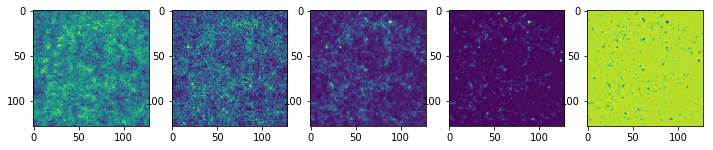

In [16]:
ii = 5

plt.figure(figsize = (12, 4))

plt.subplot(1,ii,1)
plt.imshow(lin[...].sum(axis=0))

plt.subplot(1,ii,2)
plt.imshow(hmesh[...].sum(axis=0))

plt.subplot(1,ii,3)
plt.imshow(ed0[...].sum(axis=0))

plt.subplot(1,ii,4)
plt.imshow(ed2[...].sum(axis=0))

plt.subplot(1,ii,5)
plt.imshow(es2[...].sum(axis=0))


# constant bias model

In [104]:
def ftomin(bb, ii=10, retp = False):
    b1, b2, bs = bb
    pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
    pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#     pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 
    
    predx = 1*b1*pxhed0 + 1*b2*pxhed2
    predx += 1*bs*pxhes2
#     predx += 1*pxhed
    
    if retp : return pred, predx
#     chisq = (((ph + pred - 2*predx)[ii])**2).real
    chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
    return chisq




[]

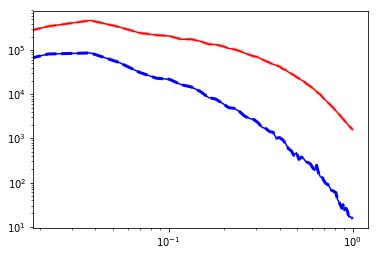

In [105]:
b1, b2, bs2 = 1, 2, 1
pa, px = ftomin([b1, b2, bs2], retp=True)
mod = ed + b1*ed0 + b2*ed2 + bs2*es2
mod =  b1*ed0 + b2*ed2 + bs2*es2

######
p1 = FFTPower(mod, mode='1d').power['power']
pxh1 = FFTPower(hmesh, second=mod, mode='1d').power['power']

######
plt.plot(k, p1, 'r')
plt.plot(k, pa, 'r--', lw=3, alpha=0.5)

plt.plot(k, pxh1, 'b')
plt.plot(k, px, 'b--', lw=3)
plt.loglog()

In [106]:
b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
b1, b2, bs2 = minimize(ftomin, [1, 1, 1]).x
# mod = ed + b1*ed0 + b2*ed2 + bs*es2
mod = b1*ed0 + b2*ed2 + bs2*es2
mod2 = ed0

print(b1, b2, bs2)
ftomin([b1, b2, bs2]), ftomin([0, 0, 0])

1.9035735933565647 -0.1127621103310436 0.23096814237713845


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxe
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:584: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxr
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:580: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxr
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:603: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc
/global/homes/c/chmod

((5868.032842517595-2.054412221591222e-14j), (45546.57595000007+0j))

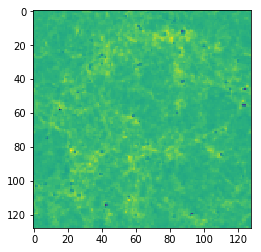

In [107]:
plt.imshow(mod[...].sum(axis=0))

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


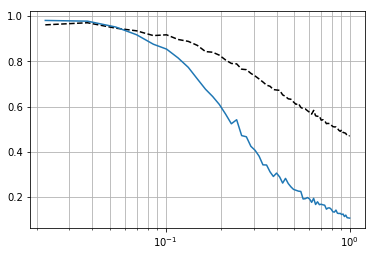

In [108]:
pmod = FFTPower(mod, mode='1d').power['power']
pxmodh = FFTPower(hmesh, second=mod, mode='1d').power['power']

pmod2 = FFTPower(mod2, mode='1d').power['power']
pxmod2h = FFTPower(hmesh, second=mod2, mode='1d').power['power']

# plt.plot(k, (pf/ph)**0.5)
plt.plot(k, pxfh/(pf*ph)**0.5, 'k--')
plt.plot(k, pxmodh/(pmod*ph)**0.5)
# plt.plot(k, pxmod2h/(pmod2*ph)**0.5)
# plt.plot(k, ph)
plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


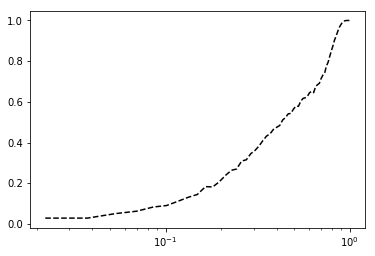

In [83]:
plt.plot(k, 1- pxmodh**2/(pmod*ph)**1, 'k--')
plt.xscale('log')

[]

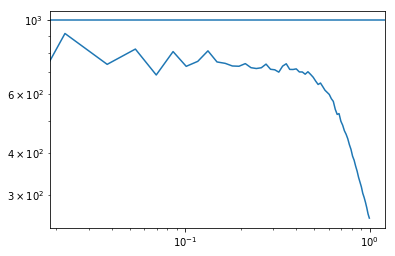

In [84]:
perr = FFTPower(hmesh - mod, mode='1d').power['power']

plt.plot(k, perr)
plt.axhline(1e3)
plt.loglog()

# Compare models

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


0.9280824783456425 -0.059067859303977135 -0.5641164202038488


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fast

0.8678295642259546 0.05348536612913141 -0.26291114857967596


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered

1.8316388636810803 -0.12846712526138362 -0.4010510025713433


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered

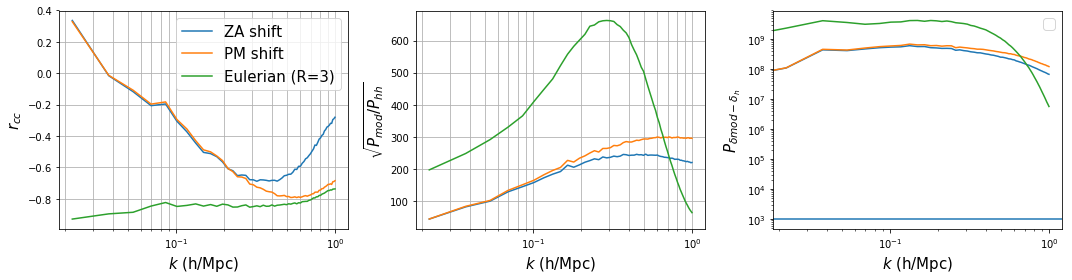

In [47]:
plt.figure(figsize=(15, 4))
fsize = 15

lbls = ['ZA shift', 'PM shift', 'Eulerian (R=3)']

ii = -1
for basemesh, pos in [[lin, zapos], [lin, fposfpm], [finsm, grid]]:
    ii += 1
    d0 = basemesh.copy()
    d2 = 1.*basemesh**2
    d2 -= d2.cmean()
    s2 = ft.shear(pm, basemesh)
    s2 -= 1.*basemesh**2
    s2 -= s2.cmean()

    ph = FFTPower(hmesh, mode='1d').power['power']

    ed = pm.paint(pos, mass=ones.readout(grid, resampler='nearest'))
    ed0 = pm.paint(pos, mass=d0.readout(grid, resampler='nearest'))
    ed2 = pm.paint(pos, mass=d2.readout(grid, resampler='nearest'))
    es2 = pm.paint(pos, mass=s2.readout(grid, resampler='nearest'))

    ped = FFTPower(ed, mode='1d').power['power']
    ped0 = FFTPower(ed0, mode='1d').power['power']
    ped2 = FFTPower(ed2, mode='1d').power['power']
    pes2 = FFTPower(es2, mode='1d').power['power']

    pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
    pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
    pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

    pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
    pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
    pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

    pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
    pxhed0 = FFTPower(hmesh, second=ed0, mode='1d').power['power']
    pxhed2 = FFTPower(hmesh, second=ed2, mode='1d').power['power']
    pxhes2 = FFTPower(hmesh, second=es2, mode='1d').power['power']


    def ftomin(bb, ii=20, retp = False):
        b1, b2, bs = bb
        pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
        pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
        pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 

        predx = 1*b1*pxhed0 + 1*b2*pxhed2
        predx += 1*bs*pxhes2
        predx += 1*pxhed

        if retp : return pred, predx
    #     chisq = (((ph + pred - 2*predx)[ii])**2).real
        chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
        return chisq


#     b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
    b1, b2, bs2 = minimize(ftomin, [1, 1, 1]).x
    mod = ed + b1*ed0 + b2*ed2 + bs*es2
#     mod = b1*ed0 + b2*ed2 + bs2*es2
    print(b1, b2, bs2)

    pmod = FFTPower(mod, mode='1d').power['power']
    pxmodh = FFTPower(hmesh, second=mod, mode='1d').power['power']
    perr = FFTPower(hmesh -mod, mode='1d').power['power']
    # plt.plot(k, (pf/ph)**0.5)

    ax = plt.subplot(131)
    plt.plot(k, pxmodh/(pmod*ph)**0.5, label=lbls[ii])
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$r_{cc}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)
    plt.legend(fontsize=fsize)
        
    ax = plt.subplot(132)
    plt.plot(k,(pmod/ph)**0.5)
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$\sqrt{P_{mod}/P_{hh}}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

    ax = plt.subplot(133)
    plt.plot(k, perr)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.ylabel('$P_{\delta{mod}-\delta_h}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

plt.axhline(1e3)
plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')
plt.legend(fontsize=fsize)
plt.tight_layout()

# Fourier bias model

In [49]:
def ftomink(bb, ii, retp = False):
    b1, b2, bs = bb
    pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
    pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#     pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 
    
    predx = 1*b1*pxhed0 + 1*b2*pxhed2
    predx += 1*bs*pxhes2
#     predx += 1*pxhed
    
    if retp : return pred, predx
    chisq = (((ph + pred - 2*predx)[ii])**2).real
    return chisq


# b1, b2, bs = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
b1k, b2k, bsk = np.zeros_like(k), np.zeros_like(k), np.zeros_like(k)
for ii in range(k.size):
    tfunc = lambda p: ftomink(p,ii)
#     b1k[ii], b2k[ii], bsk[ii] = minimize(tfunc, [1, 1, 1], method='Nelder-Mead', options={'maxfev':1000}).x
    b1k[ii], b2k[ii], bsk[ii] = minimize(tfunc, [1, 1, 1]).x

# mod = ed + b1*ed0 + b2*ed2 + bs*es2b
# mod = b1*ed0 + b2*ed2 + bs*es2
# mod2 = ed

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


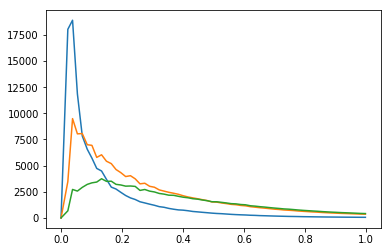

In [50]:
plt.plot(k, ped0)
plt.plot(k, ped2)
plt.plot(k, pes2)


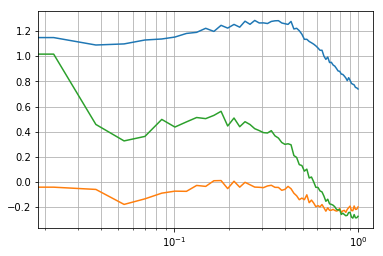

In [51]:
plt.plot(k, b1k)
plt.plot(k, b2k)
plt.plot(k, bsk)
plt.xscale('log')
plt.grid(which='both')